In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [17]:
# Load necessary libraries
import mne
from mne.decoding import Vectorizer
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Read the raw data
raw_no_med = mne.io.read_raw_fif("raw_no_med.fif", preload=True)
raw_with_med = mne.io.read_raw_fif("raw_with_med.fif", preload=True)

#Check information
display(raw_no_med.info)
display(raw_with_med.info)

#Plot the data
raw_no_med.plot();
raw_with_med.plot();

# Define the sampling frequency (same for both datasets)
fs = raw_no_med.info['sfreq']

# Create fixed length epochs
epochs_no_med = mne.make_fixed_length_epochs(raw_no_med, duration=5.0, overlap=1.0, preload=True)
epochs_with_med = mne.make_fixed_length_epochs(raw_with_med, duration=5.0, overlap=1.0, preload=True)

In [11]:
'''
# Define the length of an epoch in seconds
epoch_length = 5.0  # for example

# Calculate the number of samples per epoch
samples_per_epoch = int(epoch_length * raw_no_med.info['sfreq'])

# Create an array of event times
event_times = np.arange(0, len(raw_no_med.times), samples_per_epoch)

# Create an array of event ids
event_ids = np.ones(len(event_times))

# Combine the event times and ids into a single events array
events = np.column_stack([event_times, np.zeros(len(event_times)), event_ids]).astype(int)

# Now you can create the epochs
epochs_without_medication = mne.Epochs(raw_no_med, events=events, tmin=0, tmax=epoch_length - 1/rraw_no_med.info['sfreq'], baseline=None)

epochs_with_medication = mne.Epochs(raw_with_med, events=events, tmin=0, tmax=epoch_length - 1/raw_with_med.info['sfreq'], baseline=None)
'''

"\n# Define the length of an epoch in seconds\nepoch_length = 5.0  # for example\n\n# Calculate the number of samples per epoch\nsamples_per_epoch = int(epoch_length * raw_without_medication.info['sfreq'])\n\n# Create an array of event times\nevent_times = np.arange(0, len(raw_without_medication.times), samples_per_epoch)\n\n# Create an array of event ids\nevent_ids = np.ones(len(event_times))\n\n# Combine the event times and ids into a single events array\nevents = np.column_stack([event_times, np.zeros(len(event_times)), event_ids]).astype(int)\n\n# Now you can create the epochs\nepochs_without_medication = mne.Epochs(raw_without_medication, events=events, tmin=0, tmax=epoch_length - 1/raw_without_medication.info['sfreq'], baseline=None)\n\nepochs_with_medication = mne.Epochs(raw_with_medication, events=events, tmin=0, tmax=epoch_length - 1/raw_without_medication.info['sfreq'], baseline=None)\n"

In [12]:
epochs_without_medication = mne.make_fixed_length_epochs(raw_without_medication,duration=5,overlap=0)

epochs_with_medication = mne.make_fixed_length_epochs(raw_with_medication,duration=5,overlap=0)

In [13]:
## Now you can create the epochs with the first sample as the baseline
#epochs_without_medication = mne.Epochs(raw_without_medication, events=events, tmin=0, tmax=epoch_length - 1/raw_without_medication.info['sfreq'], baseline=(0, 0))


In [14]:
# Split the data into epochs
#epochs_without_medication = mne.Epochs(raw_without_medication, events=None, tmin=-0.1, tmax=0.8)
#epochs_with_medication = mne.Epochs(raw_with_medication, events=None, tmin=-0.1, tmax=0.8)

In [36]:
epochs_without_medication.get_data().shape

(48, 63, 5120)

In [39]:
epochs_without_medication.events[:,-1][epochs_without_medication.events[:,-1] == 1] = 0

In [44]:
epochs_without_medication.events[:,-1].shape

(48,)

In [ ]:
train_data_UN, test_data_UN, labels_train_UN, labels_test_UN = train_test_split(data_UN, labels_UN, test_size=0.3, random_state=42)

In [ ]:
# Load necessary libraries
import mne
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(train_data_UN, labels_train_UN)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

#Predictions
predictions_lr = gs_cv_lr.predict(test_data_UN)

#Evaluation
report_lr = classification_report(labels_test_UN, predictions_lr, target_names=['Unpleasant', 'Neutral'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test_UN, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_UN,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

# Features extraction

In [24]:
# Power Spectral Density (PSD)
psds_without_medication, freqs = mne.time_frequency.psd_array_welch(epochs_without_medication.get_data(), sfreq=raw_without_medication.info['sfreq'], fmin=1., fmax=40.)
psds_with_medication, freqs = mne.time_frequency.psd_array_welch(epochs_with_medication.get_data(), sfreq=raw_with_medication.info['sfreq'], fmin=1., fmax=40.)

psds_without_medication.shape

# Flatten the PSDs
psds_without_medication = psds_without_medication.reshape(len(psds_without_medication), -1)
psds_with_medication = psds_with_medication.reshape(len(psds_with_medication), -1)

# Combine the features and labels
features = np.concatenate((psds_without_medication, psds_with_medication))
labels = np.concatenate(([0] * len(psds_without_medication), [1] * len(psds_with_medication)))



# Extract features
#features_without_medication = epochs_without_medication.get_data().mean(axis=2)
#features_with_medication = epochs_with_medication.get_data().mean(axis=2)

# Create labels
#labels_without_medication = [0] * len(features_without_medication)
#labels_with_medication = [1] * len(features_with_medication)

# Combine the features and labels
#features = np.concatenate((features_without_medication, features_with_medication))
#labels = np.concatenate((labels_without_medication, labels_with_medication))



# Split the data into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, stratify=labels, shuffle=True)



In [25]:
psds_without_medication.shape

(48, 630)

In [32]:
import numpy as np
from scipy.signal import welch
import pywt
import mne
#from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

# Helper function to calculate Hjorth parameters
def hjorth_params(data):
    first_deriv = np.diff(data, axis=-1)
    second_deriv = np.diff(first_deriv, axis=-1)
    
    var_zero = np.mean(data ** 2, axis=-1)
    var_d1 = np.mean(first_deriv ** 2, axis=-1)
    var_d2 = np.mean(second_deriv ** 2, axis=-1)
    
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility
    return np.vstack([activity, mobility, complexity]).T

# Expanded feature extraction function
def extract_features(epochs):
    features = []
    
    # Extract data from MNE epochs object
    data = epochs.get_data()
    
    # Power Spectral Density (PSD)
    #psds, freqs = psd_multitaper(epochs, fmin=1, fmax=40)
    #psds = psds.reshape(len(psds), -1)  # Flatten the PSDs
    #features.append(psds)
    
    # Wavelet Transform (WT)
    coeffs = pywt.wavedec(data, wavelet='db4', level=5, axis=-1)
    wt_features = np.array([c.ravel() for c in coeffs]).reshape(len(data), -1)
    features.append(wt_features)
    
    # Time-Frequency Distributions (TFD)
    freqs = np.arange(1, 40, 2)
    n_cycles = freqs / 2.
    power = tfr_array_morlet(data, sfreq=epochs.info['sfreq'],
                             freqs=freqs, n_cycles=n_cycles,
                             output='power')
    tfd_features = power.reshape(len(data), -1)
    features.append(tfd_features)
    
    # Auto Regressive Methods (ARM)
    # Implement ARM feature extraction here (e.g., using Yule-Walker equations)
    
    # Hjorth Parameters
    hjorth_features = hjorth_params(data)
    features.append(hjorth_features)
    
    # Combine all features
    combined_features = np.concatenate(features, axis=1)
    
    return combined_features


In [33]:
extract_features(epochs_with_medication)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [ ]:
print(features)

[[1.95036023e-12 1.18768722e-12 9.58905346e-13 ... 3.40992924e-15
  4.99635282e-15 3.06046996e-15]
 [2.10727097e-12 3.12391312e-12 1.37626678e-12 ... 7.92290425e-15
  2.94275846e-15 6.18057075e-16]
 [1.32228334e-12 1.17702013e-12 1.15200473e-12 ... 8.78299922e-15
  3.52778775e-15 3.23877256e-16]
 ...
 [2.07861209e-12 2.00458775e-12 1.69308339e-12 ... 3.30442721e-14
  1.75636294e-14 2.35121609e-15]
 [1.62115564e-12 3.75501098e-12 1.69829903e-12 ... 3.21813523e-14
  1.32846982e-14 1.99658105e-15]
 [2.51829578e-12 4.06714988e-12 1.34456959e-12 ... 3.21751190e-14
  1.42002684e-14 2.96830228e-15]]


In [20]:
print(len(labels))

96


# Machine learning

In [ ]:
clf_svm_0 = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='rbf', C=1))

In [ ]:
clf_svm_0 = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='rbf', C=1))
scores = cross_val_score(clf_svm_0, features, labels, cv=5)
for i in range(len(scores)):   
    print('Accuracy of ' + str(i+1) + 'th fold is ' + str(scores[i]) + '\n')

Accuracy of 1th fold is 0.9

Accuracy of 2th fold is 1.0

Accuracy of 3th fold is 0.9473684210526315

Accuracy of 4th fold is 0.9473684210526315

Accuracy of 5th fold is 1.0



In [ ]:
#svm
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)

In [ ]:
gs_cv_svm.fit(features_train, labels_train)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 1.0


In [ ]:
#Prediction
predictions_svm = gs_cv_svm.predict(features_test)

#Evaluate
report_svm = classification_report(labels_test, predictions_svm, target_names=['Unpleasant', 'Neutral'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

SVM Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       1.00      1.00      1.00        16
     Neutral       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Accuracy of SVM model: 1.0
Precision: 1.0, Recall: 1.0, f1-score:1.0


In [ ]:
# Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(features_train, labels_train)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

#Predictions
predictions_lr = gs_cv_lr.predict(features_test)

#Evaluation
report_lr = classification_report(labels_test, predictions_lr, target_names=['Unpleasant', 'Neutral'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

Best Parameters: {'logisticregression__penalty': 'l2'}
Best Score: 1.0
LR Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       1.00      1.00      1.00        16
     Neutral       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Accuracy of LR model: 1.0
Precision: 1.0, Recall: 1.0, f1-score:1.0


In [ ]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(features_train,labels_train)

#Predictions
predictions_lda = clf_lda_pip.predict(features_test)

#Evaluation
report_lda = classification_report(labels_test, predictions_lda, target_names=['Unpleasant', 'Neutral'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

LDA Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       1.00      1.00      1.00        16
     Neutral       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Accuracy of LDA model: 1.0
Precision: 1.0, Recall: 1.0, f1-score:1.0


In [ ]:
accuracies, f1_scores = [], []
accuracies.append([acc_svm, acc_lr, acc_lda])
f1_scores.append([fscore_svm, fscore_lr, fscore_lda])

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
def plotEvalMetrics(tasks, labels, evalMetric, metricName):
    width = 0.2  # the width of the bars

    # Set position of bar on X axis
    rects1 = np.arange(len(evalMetric[:][0]))
    rects2 = [x + width for x in rects1]
    rects3 = [x + width for x in rects2]

    plt.bar(rects1, list(zip(*evalMetric))[0], color='#87CEFA', width=width, edgecolor='white', label=labels[0])
    plt.bar(rects2, list(zip(*evalMetric))[1], color='#FFE4E1', width=width, edgecolor='white', label=labels[1])
    plt.bar(rects3, list(zip(*evalMetric))[2], color='#CD5C5C', width=width, edgecolor='white', label=labels[2])

    plt.xlabel('Classification Tasks')
    plt.xticks([r + width for r in range(len(evalMetric[:][0]))], tasks)
    plt.ylabel(metricName)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', )
    plt.show()

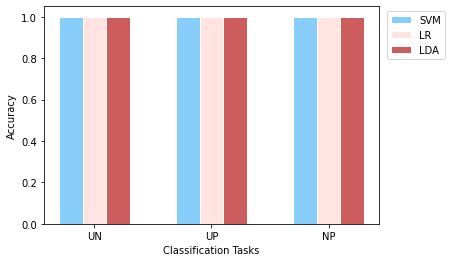

[[1.0, 1.0, 1.0]]


In [ ]:
#Plot Accuracies
tasks = ['UN', 'UP', 'NP']
labels = ['SVM', 'LR', 'LDA']
plotEvalMetrics(tasks, labels, accuracies, 'Accuracy')
print(accuracies)

In [ ]:
# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(features_train, labels_train)

# Evaluate the classifier
labels_pred = clf.predict(features_test)
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       1.00      0.19      0.32        16
           1       0.55      1.00      0.71        16

    accuracy                           0.59        32
   macro avg       0.78      0.59      0.51        32
weighted avg       0.78      0.59      0.51        32



In [ ]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
#import pyeeg
#import nolds


# Preprocess the data
raw_without_medication.filter(1., 50., fir_design='firwin')
raw_with_medication.filter(1., 50., fir_design='firwin')

# Define the length of an epoch in seconds
epoch_length = 1.0  # for example

# Calculate the number of samples per epoch
samples_per_epoch = int(epoch_length * raw_without_medication.info['sfreq'])

# Create an array of event times
event_times = np.arange(0, len(raw_without_medication.times), samples_per_epoch)

# Create an array of event ids
event_ids = np.ones(len(event_times))

# Combine the event times and ids into a single events array
events = np.column_stack([event_times, np.zeros(len(event_times)), event_ids]).astype(int)

# Now you can create the epochs
epochs_without_medication = mne.Epochs(raw_without_medication, events=events, tmin=0, tmax=epoch_length - 1/raw_without_medication.info['sfreq'], baseline=None)
epochs_with_medication = mne.Epochs(raw_with_medication, events=events, tmin=0, tmax=epoch_length - 1/raw_with_medication.info['sfreq'], baseline=None)

# Feature extraction

# Power Spectral Density (PSD)
psds_without_medication, freqs = mne.time_frequency.psd_array_welch(epochs_without_medication.get_data(), sfreq=raw_without_medication.info['sfreq'], fmin=1., fmax=50.)
psds_with_medication, freqs = mne.time_frequency.psd_array_welch(epochs_with_medication.get_data(), sfreq=raw_with_medication.info['sfreq'], fmin=1., fmax=50.)


# Bandpower
delta = (1, 4)
theta = (4, 8)
alpha = (8, 13)
beta = (13, 30)
gamma = (30, 50)

#bandpower_without_medication = np.array([pyeeg.band_power(epoch, delta, theta, alpha, beta, gamma) for epoch in epochs_without_medication.get_data()])
#bandpower_with_medication = np.array([pyeeg.band_power(epoch, delta, theta, alpha, beta, gamma) for epoch in epochs_with_medication.get_data()])

# Statistical features
mean_without_medication = np.mean(epochs_without_medication.get_data(), axis=2)
mean_with_medication = np.mean(epochs_with_medication.get_data(), axis=2)

std_without_medication = np.std(epochs_without_medication.get_data(), axis=2)
std_with_medication = np.std(epochs_with_medication.get_data(), axis=2)

# Non-linear features
#hurst_without_medication = np.array([nolds.hurst_rs(epoch) for epoch in epochs_without_medication.get_data()])
#hurst_with_medication = np.array([nolds.hurst_rs(epoch) for epoch in epochs_with_medication.get_data()])

# Combine the features and labels
features = np.concatenate((psds_without_medication, psds_with_medication, mean_without_medication, mean_with_medication, std_without_medication, std_with_medication))
labels = np.concatenate(([0] * len(psds_without_medication), [1] * len(psds_with_medication)))

# Split the data into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(features_train, labels_train)

# Evaluate the classifier
labels_pred = clf.predict(features_test)
print(classification_report(labels_test, labels_pred))


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    3.0s finished


- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
241 matching events found


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    4.2s finished


No baseline correction applied
0 projection items activated
Not setting metadata
241 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 241 events and 1024 original time points ...
1 bad epochs dropped
Effective window size : 0.250 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Using data from preloaded Raw for 241 events and 1024 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s finished


1 bad epochs dropped
Effective window size : 0.250 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Using data from preloaded Raw for 240 events and 1024 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s finished


Using data from preloaded Raw for 240 events and 1024 original time points ...
Using data from preloaded Raw for 240 events and 1024 original time points ...
Using data from preloaded Raw for 240 events and 1024 original time points ...


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 2 dimension(s)